In [67]:
from pathlib import Path
from typing import Optional
from omegaconf import DictConfig

import logging
import torch
import matplotlib.pyplot as plt

from tabularbench.core.enums import DatasetSize, ModelName, Task
from tabularbench.core.get_model import get_model
from tabularbench.core.get_trainer import get_trainer

from tabularbench.data.dataset_openml import OpenMLDataset
from tabularbench.results.run_metrics import RunMetrics
from tabularbench.config.config_run import ConfigRun
from tabularbench.utils.paths_and_filenames import PATH_TO_OPENML_DATASETS
from tabularbench.utils.set_seed import set_seed
from tabularbench.core.run_experiment import run_experiment


cfg = ConfigRun(
    output_dir = "output_run_experiment",
    device = torch.device("cuda:6"),
    model_name = ModelName.FOUNDATION,
    seed = 0,
    task = Task.CLASSIFICATION,
    dataset_size = DatasetSize.MEDIUM,
    datafile_path=Path(PATH_TO_OPENML_DATASETS) / "whytrees_44156_MEDIUM.nc",
    openml_dataset_id = 44156,
    openml_dataset_name = "electricity",
    hyperparams = DictConfig({
        'n_features': 100,
        'n_classes': 10,
        'dim': 512,
        'n_layers': 12,
        'n_heads': 4,
        'attn_dropout': 0.0,
        'y_as_float_embedding': True,
        'linear_attention': False,
        'max_samples_support': 10000,
        'max_samples_query': 10000,
        'max_epochs': 0,
        'optimizer': 'adamw',
        'lr': 1.e-5,
        'weight_decay': 0,
        'lr_scheduler': False,
        'lr_scheduler_patience': 30,
        'early_stopping_patience': 40,
        'use_pretrained_weights': True,
        'n_ensembles': 1,
        'use_quantile_transformer': True,
        'use_feature_count_scaling': True
    })
)

tabpfn_weights = 'tabularbench/models/tabPFN/prior_diff_real_checkpoint_n_0_epoch_42.cpkt'
foundation_forest_weights = 'outputs_done/foundation_forest_big_300k/weights/model_step_300000.pt'
foundation_pfn_weights = 'outputs_done/foundation_tabpfn_big_300k/weights/model_step_300000.pt'
foundation_forest_128_weights = 'outputs_done/foundation_forest_dim_128/weights/model_step_300000.pt'
foundation_forest_256_weights = 'outputs_done/foundation_forest_dim_256/weights/model_step_300000.pt'

In [68]:
import numpy as np

dataset = OpenMLDataset(cfg.datafile_path, cfg.task)
metrics = RunMetrics()

x_train, x_val, x_test, y_train, y_val, y_test, categorical_indicator = next(dataset.split_iterator())

# variables 0 and 3 are the most important ones (as selected by random forest feature importance)
features = [0, 3]

x_train = x_train[:, features]
x_val = x_val[:, features]
x_test = x_test[:, features]

In [69]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

coolwarm = plt.get_cmap('coolwarm')
coolwarm_trunc = truncate_colormap(coolwarm, 0.1, 0.9)

In [70]:
def irregularity_value(pred_grid):

    pred = pred_grid[:, :, 0]

    pred_middle = pred[1:-1, 1:-1]
    pred_up = pred[:-2, 1:-1]
    pred_down = pred[2:, 1:-1]
    pred_left = pred[1:-1, :-2]
    pred_right = pred[1:-1, 2:]

    pred_diff = np.abs(pred_middle - pred_up) + np.abs(pred_middle - pred_down) + np.abs(pred_middle - pred_left) + np.abs(pred_middle - pred_right)

    return pred_diff.sum() / pred_diff.size

In [71]:
import einx

x1 = (np.arange(1000) / 1000 - 0.5) * 4
x2 = (np.arange(1000) / 1000 - 0.5) * 4

x_mesh1, x_mesh2 = np.meshgrid(x1, x2)

x_mesh1_col = einx.rearrange('h w -> (h w)', x_mesh1)
x_mesh2_col = einx.rearrange('h w -> (h w)', x_mesh2)

x_grid = np.zeros((1000000, x_test.shape[1]))
x_grid[:, 0] = x_mesh1_col
x_grid[:, 1] = x_mesh2_col

In [72]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000, alpha=1e-4)
mlp.fit(x_train, y_train)
score_test_mlp = mlp.score(x_test, y_test)

score_test_mlp

0.7871262291792093

Text(0.5, 1.0, 'MLP (acc: 0.787, irreg: 0.0039)')

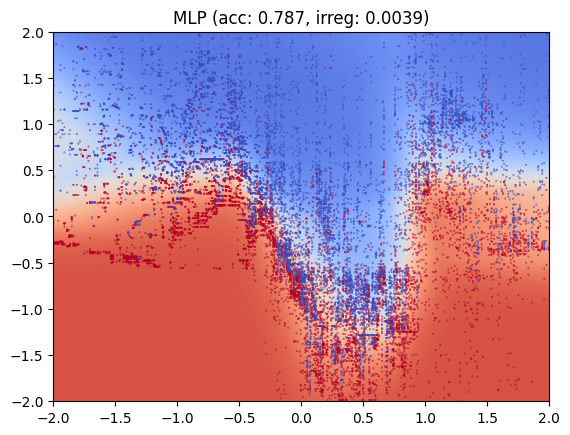

In [73]:
preds = mlp.predict_proba(x_grid)
preds = einx.rearrange('(h w) c -> h w c', preds, w=1000)

irreg_value = irregularity_value(preds)

plt.pcolormesh(x_mesh1, x_mesh2, preds[:, :, 0], cmap=coolwarm_trunc)
plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
plt.ylim(-2, 2)
plt.xlim(-2, 2)

plt.title(f"MLP (acc: {score_test_mlp:.3f}, irreg: {irreg_value:.4f})")

In [74]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(x_train, y_train)
score_test_rf = clf.score(x_test, y_test)

score_test_rf


0.8693558097531607

In [75]:
clf.feature_importances_

array([0.41942146, 0.58057854])

Text(0.5, 1.0, 'Random Forest (acc: 0.869, irreg: 0.0815)')

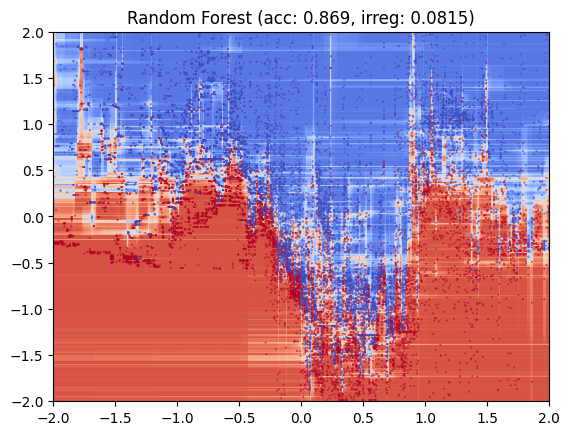

In [76]:
preds = clf.predict_proba(x_grid)
preds = einx.rearrange('(h w) c -> h w c', preds, w=1000)

irreg_value = irregularity_value(preds)

plt.pcolormesh(x_mesh1, x_mesh2, preds[:, :, 0], cmap=coolwarm_trunc)
plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
plt.ylim(-2, 2)
plt.xlim(-2, 2)
plt.title(f"Random Forest (acc: {score_test_rf:.3f}, irreg: {irreg_value:.4f})")

In [77]:
from tabularbench.core.dataset_split import make_dataset_split
from tabularbench.core.run_experiment import Data

def make_boundary_plot(name: str):

    data = Data.from_standard_datasplits(x_train, x_val, x_test, y_train, y_val, y_test, cfg.task)

    model = get_model(cfg, data.x_train_cut, data.y_train_cut, categorical_indicator)
    trainer = get_trainer(cfg, model, dataset.n_classes)
    trainer.train(data.x_train_cut, data.y_train_cut, data.x_val_earlystop, data.y_val_earlystop)
    prediction_metrics_test = trainer.test(data.x_train_and_val, data.y_train_and_val, data.x_test, data.y_test)

    score_test = prediction_metrics_test.score

    preds_pfn_raw = trainer.predict(x_train, y_train, x_grid)
    preds_pfn = einx.softmax('n [c]', preds_pfn_raw)
    preds_pfn = einx.rearrange('(h w) c -> h w c', preds_pfn, w=1000)

    irreg_value = irregularity_value(preds_pfn)

    plt.pcolormesh(x_mesh1, x_mesh2, preds_pfn[:, :, 0], cmap=coolwarm_trunc)
    plt.scatter(x_test[:, 0], x_test[:, 1], c=1-y_test, s=0.1, cmap=coolwarm)
    plt.ylim(-2, 2)
    plt.xlim(-2, 2)
    plt.title(f"{name} (acc: {score_test:.3f}, irreg: {irreg_value:.4f})")

2024-03-25 17:17:14.955 | INFO     | tabularbench.core.trainer_finetune:train:81 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.4424 | Val score: 0.7845


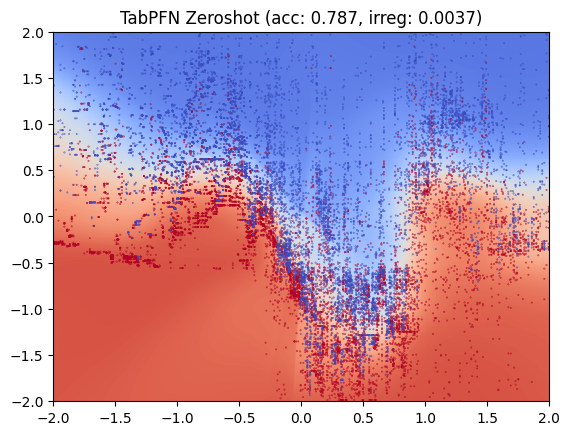

In [78]:
cfg.hyperparams['path_to_weights'] = tabpfn_weights
cfg.hyperparams['max_epochs'] = 0
cfg.hyperparams['dim'] = 512
cfg.model_name = ModelName.TABPFN

make_boundary_plot("TabPFN Zeroshot")

2024-03-25 17:18:27.817 | INFO     | tabularbench.core.trainer_finetune:train:81 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.4371 | Val score: 0.7910
2024-03-25 17:18:28.917 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 001 | Train loss: 0.4466 | Train score: 0.7800 | Val loss: 0.4319 | Val score: 0.7935
2024-03-25 17:18:30.016 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 002 | Train loss: 0.4480 | Train score: 0.7731 | Val loss: 0.4440 | Val score: 0.7905
2024-03-25 17:18:30.888 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 003 | Train loss: 0.4297 | Train score: 0.7794 | Val loss: 0.4305 | Val score: 0.8020
2024-03-25 17:18:31.992 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 004 | Train loss: 0.4208 | Train score: 0.7969 | Val loss: 0.4287 | Val score: 0.8020
2024-03-25 17:18:33.163 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 005 | Train loss: 0.4590 | Train sco

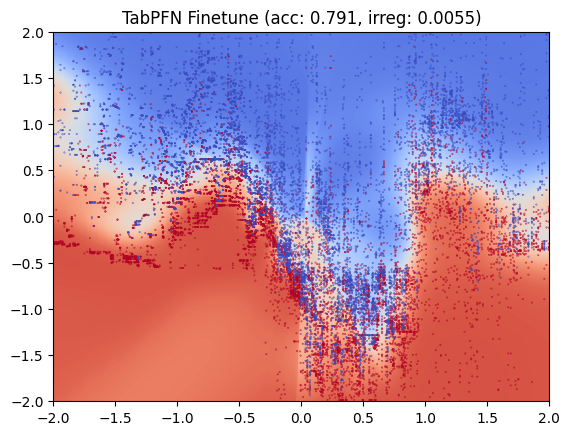

In [79]:
cfg.hyperparams['max_epochs'] = 300

make_boundary_plot("TabPFN Finetune")

2024-03-25 17:20:21.374 | INFO     | tabularbench.core.trainer_finetune:train:81 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.4693 | Val score: 0.7590


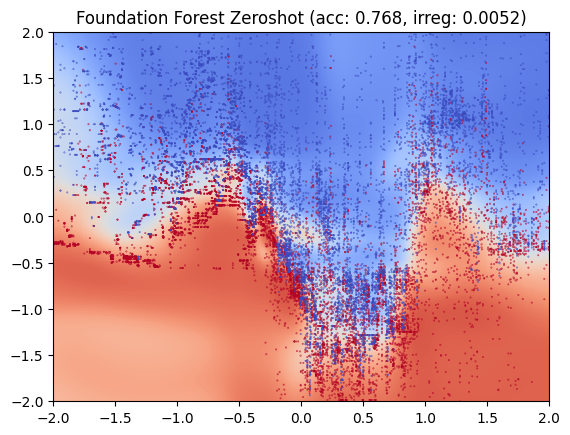

In [80]:
cfg.model_name = ModelName.FOUNDATION
cfg.hyperparams['path_to_weights'] = foundation_forest_weights
cfg.hyperparams['max_epochs'] = 0
cfg.hyperparams['dim'] = 512

make_boundary_plot("Foundation Forest Zeroshot")


2024-03-25 17:21:40.629 | INFO     | tabularbench.core.trainer_finetune:train:81 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.4621 | Val score: 0.7805
2024-03-25 17:21:42.071 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 001 | Train loss: 0.4755 | Train score: 0.7519 | Val loss: 0.4678 | Val score: 0.7680
2024-03-25 17:21:42.933 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 002 | Train loss: 0.4932 | Train score: 0.7550 | Val loss: 0.4253 | Val score: 0.8055
2024-03-25 17:21:44.652 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 003 | Train loss: 0.4370 | Train score: 0.7881 | Val loss: 0.4257 | Val score: 0.8015
2024-03-25 17:21:45.514 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 004 | Train loss: 0.4355 | Train score: 0.7950 | Val loss: 0.4246 | Val score: 0.7990
2024-03-25 17:21:46.959 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 005 | Train loss: 0.4468 | Train sco

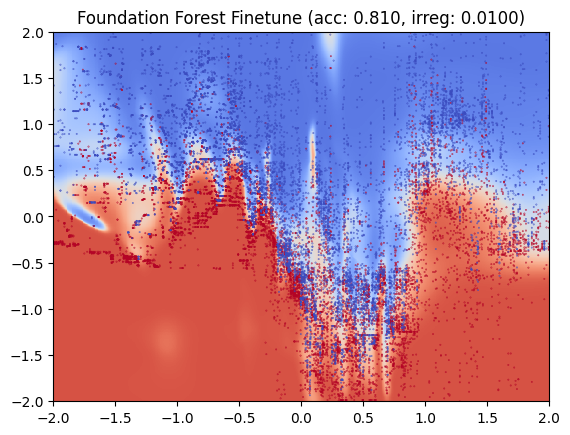

In [81]:
cfg.hyperparams['max_epochs'] = 300

make_boundary_plot("Foundation Forest Finetune")

2024-03-25 17:27:18.236 | INFO     | tabularbench.core.trainer_finetune:train:81 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.4548 | Val score: 0.7790


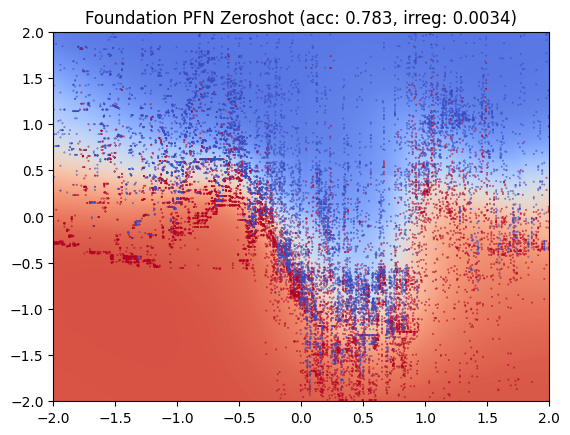

In [82]:
cfg.hyperparams['path_to_weights'] = foundation_pfn_weights
cfg.hyperparams['max_epochs'] = 0

make_boundary_plot("Foundation PFN Zeroshot")

2024-03-25 17:28:37.802 | INFO     | tabularbench.core.trainer_finetune:train:81 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.4534 | Val score: 0.7900
2024-03-25 17:28:39.362 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 001 | Train loss: 0.4460 | Train score: 0.7900 | Val loss: 0.4363 | Val score: 0.7980
2024-03-25 17:28:41.154 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 002 | Train loss: 0.4422 | Train score: 0.7788 | Val loss: 0.4411 | Val score: 0.7865
2024-03-25 17:28:42.121 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 003 | Train loss: 0.4588 | Train score: 0.7781 | Val loss: 0.4358 | Val score: 0.7925
2024-03-25 17:28:43.537 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 004 | Train loss: 0.4404 | Train score: 0.7837 | Val loss: 0.4315 | Val score: 0.7935
2024-03-25 17:28:45.200 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 005 | Train loss: 0.4386 | Train sco

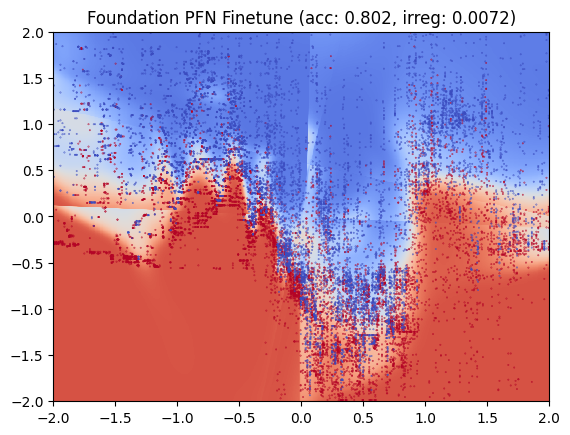

In [83]:
cfg.hyperparams['max_epochs'] = 300

make_boundary_plot("Foundation PFN Finetune")

2024-03-25 17:33:01.517 | INFO     | tabularbench.core.trainer_finetune:train:81 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.4662 | Val score: 0.7660
2024-03-25 17:33:02.388 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 001 | Train loss: 0.4516 | Train score: 0.7662 | Val loss: 0.4485 | Val score: 0.7895
2024-03-25 17:33:03.339 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 002 | Train loss: 0.4254 | Train score: 0.7919 | Val loss: 0.4497 | Val score: 0.7850
2024-03-25 17:33:04.029 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 003 | Train loss: 0.4249 | Train score: 0.8094 | Val loss: 0.4492 | Val score: 0.7890
2024-03-25 17:33:04.701 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 004 | Train loss: 0.4378 | Train score: 0.7981 | Val loss: 0.4477 | Val score: 0.7910
2024-03-25 17:33:05.520 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 005 | Train loss: 0.4305 | Train sco

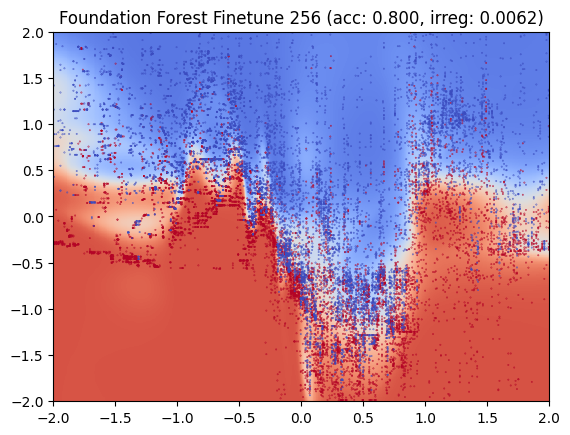

In [84]:
cfg.hyperparams['path_to_weights'] = foundation_forest_256_weights
cfg.hyperparams['max_epochs'] = 300
cfg.hyperparams['dim'] = 256

make_boundary_plot("Foundation Forest Finetune 256")

2024-03-25 17:36:18.991 | INFO     | tabularbench.core.trainer_finetune:train:81 - Epoch 000 | Train loss: -.---- | Train score: -.---- | Val loss: 0.4580 | Val score: 0.7720


2024-03-25 17:36:19.782 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 001 | Train loss: 0.4445 | Train score: 0.7969 | Val loss: 0.4515 | Val score: 0.7725
2024-03-25 17:36:20.456 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 002 | Train loss: 0.4543 | Train score: 0.7794 | Val loss: 0.4515 | Val score: 0.7735
2024-03-25 17:36:21.133 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 003 | Train loss: 0.4249 | Train score: 0.8019 | Val loss: 0.4510 | Val score: 0.7780
2024-03-25 17:36:21.799 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 004 | Train loss: 0.4273 | Train score: 0.7937 | Val loss: 0.4497 | Val score: 0.7835
2024-03-25 17:36:22.471 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 005 | Train loss: 0.4322 | Train score: 0.7956 | Val loss: 0.4492 | Val score: 0.7835
2024-03-25 17:36:23.127 | INFO     | tabularbench.core.trainer_finetune:train:92 - Epoch 006 | Train loss: 0.4336 | Train sco

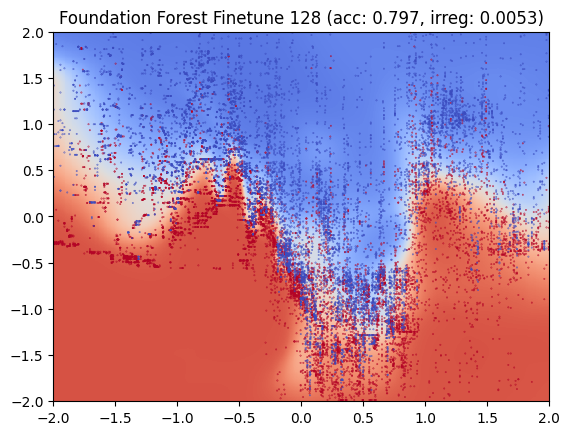

In [85]:
cfg.hyperparams['path_to_weights'] = foundation_forest_128_weights
cfg.hyperparams['max_epochs'] = 300
cfg.hyperparams['dim'] = 128

make_boundary_plot("Foundation Forest Finetune 128")